In [1]:
from eta.eta import * 

In [2]:
import random
from collections import defaultdict
from itertools import combinations
import numpy as np
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = [13.0, 8.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'large'
import matplotlib.pyplot as plt
plt.style.use(['ggplot', 'seaborn-deep'])

In [3]:
# params
N = 50
gradation = 5
mu = np.arange(1, 5)

In [4]:

def generate_data_group(N):
    Wr = np.eye(N) # winning rate

    true_grad = []
    for i in range(N):
        true_grad.append(np.random.randint(1, gradation))
    
    for i in range(N):
        for j in range(i+1, N):
            gi = true_grad[i]
            gj = true_grad[j]

            vi = true_grad[i]
            vj = true_grad[j]

            Wr[i, j] = vi / (vi + vj)
            Wr[j, i] = vj / (vi + vj)
    
    grouped = defaultdict(list)
    for i, g in enumerate(true_grad):
        grouped[g].append(i)
        
    all_swappable_pair = []
    for (gi, gj) in combinations(range(1, gradation+1), 2):
        for i in grouped[gi]:
            for j in grouped[gj]:
                all_swappable_pair.append((i, j))
            
    return true_grad, Wr, all_swappable_pair



In [5]:
def true_tau_b(ranking, true_grad):
    N = len(ranking)
    
    nc = 0
    nd = 0
    t, u = 0, 0 
    for i in range(N):
        for j in range(i+1, N):
            x = ranking[i]
            y = ranking[j]
            if true_grad[x] > true_grad[y]:
                nc += 1
            elif true_grad[x] < true_grad[y]:
                nd += 1
            if true_grad[x] == true_grad[y]:
                u += 1
    n0 = N * (N - 1) / 2
    return (nc - nd) / np.sqrt((n0 - t)*(n0 - u))


def calc_tau_two_serp(serp_ref, serp_tgt):
    assert len(serp_ref) == len(serp_tgt)  
    N = len(serp_ref)
    
    inv_dict_ref = {}
    for i in range(N):
        inv_dict_ref[serp_ref[i]] = i 
    
    nc, nd = 0, 0
    for i in range(N):
        for j in range(i+1, N):
            x = serp_tgt[i]
            y = serp_tgt[j]
            if inv_dict_ref[x] < inv_dict_ref[y]: 
                nc += 1
            else:
                nd += 1
    return (nc - nd) / (N * (N - 1) / 2)      


def calc_tau_b(ranking, pref):
    N = len(ranking)
    
    nc, nd = 0, 0
    t, u = 0, 0 
    for i in range(N):
        for j in range(i+1, N):
            x = ranking[i]
            y = ranking[j]
            if pref[x, y] > pref[y, x]:
                nc += 1
            elif pref[x, y] < pref[y, x]:
                nd += 1
            else:
                t += 1
    n0 = N * (N - 1) / 2
    return (nc - nd) / np.sqrt((n0 - t)*(n0 - u))


def mm(wl_table):
    N = len(wl_table)
    Rt = np.ones(N) * 1500
        
    W = np.sum(wl_table, axis=1)
    
    for i in range(300):
        ds = []
        new_Rt = np.copy(Rt)
        for i in range(N):
            n_ab = wl_table[i, :] + wl_table[:, i]
            non_zero = (n_ab != 0)
            n_ab = n_ab[non_zero]
            rs = (Rt[i] + Rt)[non_zero]
            new_Rt_i = W[i] / np.sum(n_ab / rs)
            new_Rt[i] = new_Rt_i
        Rt = new_Rt
    
    return Rt


def simulate_rr(num_observation=100, T=100, num_rater=3):
    true_grad, Wr, all_swappable_pair = generate_data_group(N)
    wl_table = np.zeros((N, N))
    
    pairs = list(combinations(range(N), 2))
    
    random.shuffle(pairs)
    seen = set()
    for (i, j) in random.sample(pairs, num_observation):
        for vote in np.random.binomial(1, Wr[i, j], num_rater):
            if vote == 1:
                wl_table[i, j] += 1
            else:
                wl_table[j, i] += 1
    
    Rt = mm(wl_table)
    
    wl_table /= num_rater
    wl_table_mm = np.zeros((N, N))
    wl_for_etau_mm = np.zeros((N, N))
    wl_for_etau = np.copy(wl_table)
    wl_for_tau = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            if wl_table[i, j] > wl_table[j, i]:
                wl_for_tau[i, j] = 1
            else:
                wl_for_tau[j, i] = 1
                
            if wl_table[i, j] == 0 and wl_table[j, i] == 0:
                wl_for_etau[i, j] = 0.5
                wl_for_etau[j, i] = 0.5
                
            if Rt[i] > Rt[j]:
                wl_table_mm[i, j] = 1
                wl_table_mm[j, i] = 0
            elif Rt[i] > Rt[j]:
                wl_table_mm[i, j] = 0
                wl_table_mm[j, i] = 1
            else:
                wl_table_mm[i, j] = 1
                wl_table_mm[j, i] = 1
                
            wl_for_etau_mm[i, j] = Rt[i] / (Rt[i] + Rt[j])
            wl_for_etau_mm[j, i] = Rt[j] / (Rt[i] + Rt[j])
            
    true_tau_list = []
    tau_b_mm_list = []
    etau1_list = []
    etau1_mm_list = []
    ideal = list(np.argsort(true_grad)[::-1])
    swappable_pair = list(all_swappable_pair)
    random.shuffle(swappable_pair)
    for m in range(T):
        if m % 20 == 0:
            ideal = list(np.argsort(true_grad)[::-1])
        i, j = random.choice(swappable_pair)
        rank_i = ideal.index(i)
        rank_j = ideal.index(j)
        ideal[rank_i], ideal[rank_j] = ideal[rank_j], ideal[rank_i] 
        true_tau_list.append(true_tau_b(ideal, true_grad))
        tau_b_mm_list.append(calc_tau_b(ideal, wl_table_mm))
        etau1_mm_list.append(eta(ideal, wl_for_etau_mm))
        etau1_list.append(eta(ideal, wl_for_etau))
    
    return true_tau_list, tau_b_mm_list, etau1_list, etau1_mm_list


In [6]:
MC_TRIALS = 10

rr_tau_b_ls = []
rr_eta_ls = []
rr_eta_mm_ls = []
for obsr in np.arange(200, 1200, 100):
    print(obsr)
    rr_tau_b = []
    rr_eta = []
    rr_eta_mm = []
    for i in range(MC_TRIALS):
        ttl, tbl, etl, etml = simulate_rr(num_observation=obsr, T=500)
        rr_tau_b.append(np.corrcoef(ttl, tbl)[0, 1])
        rr_eta.append(np.corrcoef(ttl, etl)[0, 1])
        rr_eta_mm.append(np.corrcoef(ttl, etml)[0, 1])
    rr_tau_b_ls.append(rr_tau_b)
    rr_eta_ls.append(rr_eta)
    rr_eta_mm_ls.append(rr_eta_mm)


300


400


500


600


700


800


900


1000


1100


In [7]:
def plt_errbar_obs(x, rr_tau_ls, label):
    sorted_rr_tau_ls = np.sort(rr_tau_ls, axis=1)
    y = np.average(sorted_rr_tau_ls, axis=1)
    y_pos = np.max(sorted_rr_tau_ls, axis=1) - y
    y_neg = y - np.min(sorted_rr_tau_ls, axis=1)
    plt.errorbar(x, y, yerr=[y_neg, y_pos], fmt='o', capsize=5, label=label, linestyle='dotted')       

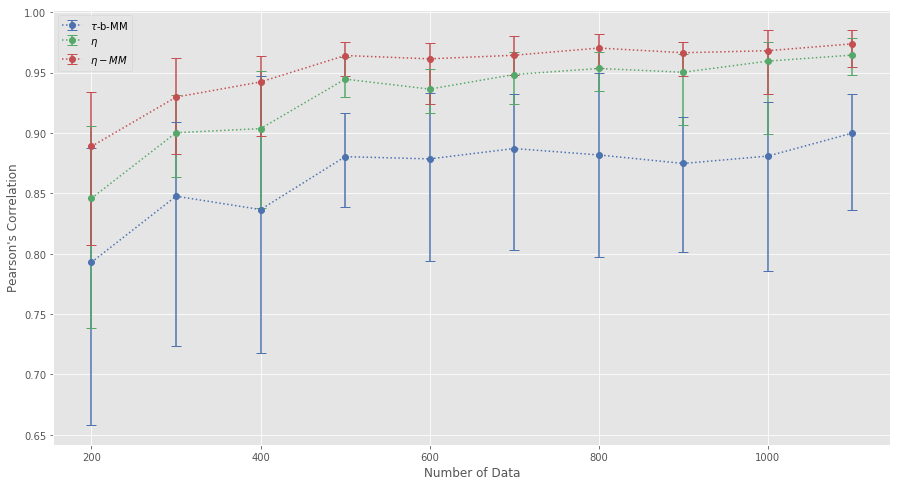

In [8]:
plt.figure(figsize=(15, 8))
plt_errbar_obs(np.arange(200, 1200, 100), rr_tau_b_ls, '$\\tau$-b-MM')
plt_errbar_obs(np.arange(200, 1200, 100), rr_eta_ls, '$\eta$')
plt_errbar_obs(np.arange(200, 1200, 100), rr_eta_mm_ls, '$\eta-MM$')
plt.ylabel("Pearson's Correlation")
plt.xlabel("Number of Data")
plt.legend()